# Business Goal
In this notebook, I will analyze a health insurance company's data to predict future insurance claim amounts and identify factors that lead to higher healthcare costs. The insurance dataset consists of 1,338 policyholders with 7 attributes that describe their health and demographic information, including their age, gender, BMI, and smoking status. The variable we would like to predict is the total claim amount, charges, that were billed to the insurance company. To provide a more targeted cost prediction, I will build a model for each of the four regions where the company's policyholders reside in: the Southwest, Southeast, Northwest, and Northeast regions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot, plot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
print('There are {} observations and {} features in the data set'.format(df.shape[0],df.shape[1]))
print('There are {} missing values in the data'.format(df.isnull().sum().sum()))
df['smoker'] = df['smoker'].apply(lambda x: 'smoker' if x=='yes' else 'non-smoker')
df.head()

There are 1338 observations and 7 features in the data set
There are 0 missing values in the data


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,smoker,southwest,16884.92400
1,18,male,33.770,1,non-smoker,southeast,1725.55230
2,28,male,33.000,3,non-smoker,southeast,4449.46200
3,33,male,22.705,0,non-smoker,northwest,21984.47061
4,32,male,28.880,0,non-smoker,northwest,3866.85520


# Summary Statistics of Numeric Columns

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Exploratory Data Analysis

In [4]:
cat_cols = df.select_dtypes(include=['object']).columns.to_list()
for i in cat_cols:
    obs = df[i].value_counts()
    avg_charges = df.groupby(i)['charges'].mean()
    display(pd.DataFrame({'Number of Policyholders':obs, 'Average Charges Amount':avg_charges}).style.set_caption('Variable:{}'.format(i)))

,Number of Policyholders,Average Charges Amount
female,662,12569.578844
male,676,13956.751178


,Number of Policyholders,Average Charges Amount
non-smoker,1064,8434.268298
smoker,274,32050.231832


,Number of Policyholders,Average Charges Amount
northeast,324,13406.384516
northwest,325,12417.575374
southeast,364,14735.411438
southwest,325,12346.937377


### Insurance Costs by Region

In [5]:
fig = px.box(df,x='region',y='charges', color='region',title='Distribution of Insurance Costs by Region')
fig.show()

For each region, the boxplots show insurance charges are positively skewed with several large outliers. Insurance charges are more variable in the Southeast region, which contains the highest claim in the data set at over 63,000 dollars as well as the lowest claim at 1,121 dollars.

### Insurance Costs by Smoking status

In [6]:
trace0 = go.Box(x=df['smoker'],y=df['charges'])
layout = go.Layout(title='Distribution of Insurance Costs by smoking status',
                   xaxis=dict(title='smoking status'),
                   yaxis=dict(title='charges'))
data = [trace0]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [7]:
smoker = df[df.smoker=='smoker']
non_smoker = df[df.smoker=='non-smoker']

trace1 = go.Histogram(x=smoker.charges,opacity=0.75,name='smoker')      
trace2 = go.Histogram(x=non_smoker.charges,opacity=0.75,name='non_smoker')

data = [trace1,trace2]
layout = go.Layout(barmode='overlay',title='Distribution of Insurance Costs by smoking status')

fig = go.Figure(data=data,layout=layout)
iplot(fig)

The median claim amount of non-smokers is around 7,300 dollars, which is quite lower than the median claim of smokers at over 34,000 dollars. The distribution of insurance costs between the groups is also notably different. For non-smokers, the distribution is skewed to the right, while claim amounts for smokers have more variability with a wider spread in the boxplot

### Insurance Costs by Age Group and Smoking status

In [8]:
df_copy = df.copy()
df_copy['Age Group'] = ['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else '45 to 59 years' if (i>=45)&(i<59) else '60 and over' for i in df_copy.age]
age_smoker_df = df_copy.groupby(['Age Group','smoker'])['charges'].mean().reset_index()

fig = px.bar(age_smoker_df,x='Age Group',y='charges',color='smoker',text='charges',barmode='group',opacity=0.75,title='Insurance Costs by Age and Smoking Status')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
fig.show()

Among each age group, insurance charges are significantly higher on average in smokers than non-smokers. We also see higher claim amounts as age increases with the most expensive claims in the 60 and over age group.

### Insurance Costs VS Body Mass Index

In [9]:
fig = px.scatter(df_copy,x='bmi',y='charges',color='smoker',size='charges',title='Insurance costs VS Body Mass Index')
fig.show()

Claim amounts are positively correlated to body mass index. Among smokers, insurance charges tend to increase with BMI.

### Insurance Costs by Region and Smoking Status

In [10]:
region_smoker_df = df_copy.groupby(['region','smoker'])['charges'].mean().reset_index()
fig = px.bar(region_smoker_df,x='region',y='charges',color='smoker',text='charges',barmode='group',opacity=0.75,title='Insurance Costs by Region and Smoking Status')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')
fig.show()

Non-smokers tend to have smaller insurance claims on average than smokers at a little under 10,000 dollar within each region, while smokers' claims range from an average of 29,000 dollar to over 35,000 dollar. 

# Heatmap

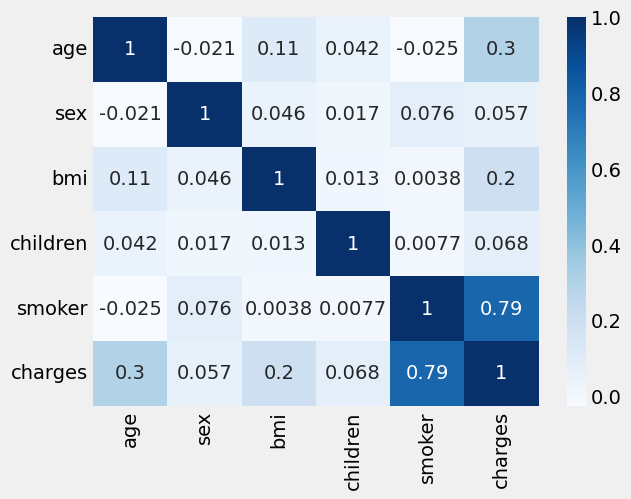

In [11]:
df['sex'] = df['sex'].apply(lambda x: 1 if x=='male' else 0)
df['smoker'] = df['smoker'].apply(lambda x: 1 if x=='smoker' else 0)

sns.heatmap(df.corr(),annot=True,cmap='Blues')
plt.show()

The correlation matrix shows that smokers have a strong positive relationship with insurance charges at 0.79, but overall, the variables in the dataset are not too highly correlated with each other.

# Linear Regression

In [12]:
models = ['Linear Regression','SVM','Random Forest','Gradient Boosting','XGBoost']
res = pd.DataFrame(columns=['Avg. RMSE','Avg. Adjusted R2'],index=models)
regions = df.region.unique()
scaler = StandardScaler()

actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []

for i in regions:
    print("\nRegion: {}\n".format(i))
    df_reg = df[df.region==i]
    X = df_reg.drop(['charges','region'],axis=1)
    y = df_reg.charges
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    # Linear Regression
    lr = LinearRegression().fit(X_train_scaled,y_train)
    y_pred = lr.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred)).round(2)
    r2 = r2_score(y_test,y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test_scaled.shape[1]-1)
    
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100,adj_r2*100))


Region: southwest

Test Error (RMSE) = 6,883.38
R-Squared = 72.20%, Adjusted R-Squared = 69.85%

Region: southeast

Test Error (RMSE) = 6,245.44
R-Squared = 74.30%, Adjusted R-Squared = 72.38%

Region: northwest

Test Error (RMSE) = 6,560.9
R-Squared = 46.68%, Adjusted R-Squared = 42.16%

Region: northeast

Test Error (RMSE) = 6,690.61
R-Squared = 71.08%, Adjusted R-Squared = 68.63%


In [13]:
res.iloc[0,0]=pd.Series(rmses).mean()
res.iloc[0,1]=pd.Series(adj_r2_scores).mean()
print(res.iloc[:1,].sort_values("Avg. RMSE"))

                   Avg. RMSE Avg. Adjusted R2
Linear Regression  6595.0825         0.632537


Out of the four models, linear regression performs the best predicting insurance costs in the southeast region with an adjusted  𝑅2 of 74.3% and an RMSE of about 6,245. This indicates that our model can explain about 74% of the variation in insurance costs in the southeast region and leads to test predictions that are within approximately 6240 dollar of the true median claim amount.

# Support Vector Regression

In [14]:
actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []
feat_importance = pd.DataFrame()

for i in regions:
    print("\nRegion: {}\n".format(i))
    df_reg = df[df.region==i]
    X = df_reg.drop(['charges','region'],axis=1)
    y = df_reg.charges
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled)
    X_test = pd.DataFrame(X_test_scaled)
    
    # Tuning SVM
    grid = {'kernel':['linear','rbf','poly','sigmoid'],
            'C' : np.logspace(-3, 3, 10)}
    svm = SVR()
    svm_cv = RandomizedSearchCV(estimator=svm, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=10, cv=3, random_state=42, n_jobs=-1)
    svm_cv.fit(X_train, y_train)
    print("Best SVM Parameters:\n",svm_cv.best_params_)
    y_pred = svm_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("\nTest Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))


Region: southwest

Best SVM Parameters:
 {'kernel': 'sigmoid', 'C': 1000.0}

Test Error (RMSE) = 10,558.01
R-Squared = 34.60%, Adjusted R-Squared = 29.06%

Region: southeast

Best SVM Parameters:
 {'kernel': 'sigmoid', 'C': 1000.0}

Test Error (RMSE) = 5,754.97
R-Squared = 78.18%, Adjusted R-Squared = 76.55%

Region: northwest

Best SVM Parameters:
 {'kernel': 'sigmoid', 'C': 1000.0}

Test Error (RMSE) = 6,923.94
R-Squared = 40.62%, Adjusted R-Squared = 35.58%

Region: northeast

Best SVM Parameters:
 {'kernel': 'sigmoid', 'C': 1000.0}

Test Error (RMSE) = 9,075.77
R-Squared = 46.78%, Adjusted R-Squared = 42.27%


In [15]:
res.iloc[1,0]=pd.Series(rmses).mean()
res.iloc[1,1]=pd.Series(adj_r2_scores).mean()
print(res.iloc[:2,].sort_values("Avg. RMSE"))

                   Avg. RMSE Avg. Adjusted R2
Linear Regression  6595.0825         0.632537
SVM                8078.1725         0.458649


# RandomForest Regressor

In [16]:
actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []
feat_importance = pd.DataFrame()

for i in regions:
    print("\nRegion: {}\n".format(i))
    df_reg = df[df.region==i]
    X = df_reg.drop(['charges','region'],axis=1)
    y = df_reg.charges
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled)
    X_test = pd.DataFrame(X_test_scaled)
    
    # Tuning SVM
    rf = RandomForestRegressor(n_estimators=1200,
                                  max_depth=15,
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  max_features=None,
                                  oob_score=True,
                                  random_state=42).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("\nTest Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))


Region: southwest


Test Error (RMSE) = 5,381.32
R-Squared = 83.01%, Adjusted R-Squared = 81.57%

Region: southeast


Test Error (RMSE) = 3,125.77
R-Squared = 93.56%, Adjusted R-Squared = 93.08%

Region: northwest


Test Error (RMSE) = 5,032.88
R-Squared = 68.62%, Adjusted R-Squared = 65.96%

Region: northeast


Test Error (RMSE) = 5,309.81
R-Squared = 81.78%, Adjusted R-Squared = 80.24%


In [17]:
res.iloc[2,0]=pd.Series(rmses).mean()
res.iloc[2,1]=pd.Series(adj_r2_scores).mean()
print(res.iloc[:3,].sort_values("Avg. RMSE"))

                   Avg. RMSE Avg. Adjusted R2
Random Forest       4712.445         0.802142
Linear Regression  6595.0825         0.632537
SVM                8078.1725         0.458649


# GradientBoosting Regressor

In [18]:
actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []
feat_importance = pd.DataFrame()

for i in regions:
    print("\nRegion: {}\n".format(i))
    df_reg = df[df.region==i]
    X = df_reg.drop(['charges','region'],axis=1)
    y = df_reg.charges
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled,columns=X.columns)
    X_test = pd.DataFrame(X_test_scaled,columns=X.columns)
    
    # Tuning 
    grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
            'subsample': [0.5, 0.8, 1],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
            'max_features': [None, 'sqrt']}
    
    gb = GradientBoostingRegressor(random_state=42)
    gb_cv = RandomizedSearchCV(estimator=gb, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=42, n_jobs=-1)
    gb_cv.fit(X_train, y_train)
    y_pred = gb_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    # Save feature importance
    feat_importance["Importance_"+str(i)]=gb_cv.best_estimator_.feature_importances_
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))


Region: southwest

Test Error (RMSE) = 5,178.78
R-Squared = 84.26%, Adjusted R-Squared = 82.93%

Region: southeast

Test Error (RMSE) = 3,127.38
R-Squared = 93.56%, Adjusted R-Squared = 93.07%

Region: northwest

Test Error (RMSE) = 5,072.61
R-Squared = 68.13%, Adjusted R-Squared = 65.43%

Region: northeast

Test Error (RMSE) = 5,426.62
R-Squared = 80.97%, Adjusted R-Squared = 79.36%


In [19]:
res.iloc[3,0]=pd.Series(rmses).mean()
res.iloc[3,1]=pd.Series(adj_r2_scores).mean()
print(res.iloc[:4,].sort_values("Avg. RMSE"))

                   Avg. RMSE Avg. Adjusted R2
Gradient Boosting  4701.3475         0.801981
Random Forest       4712.445         0.802142
Linear Regression  6595.0825         0.632537
SVM                8078.1725         0.458649


In [20]:
feat_importance.set_index(X_train.columns, inplace=True)
ft=pd.DataFrame({'Average Importance':feat_importance.mean(axis=1)})
plot_df=ft.nlargest(10, columns="Average Importance").sort_values(by='Average Importance',ascending=False)
fig = px.bar(plot_df, x='Average Importance', y=plot_df.index, text='Average Importance')
fig.show()

Using the average feature importance's from the Gradient Boosting models, the smoking status produces the highest average importance across the models with interactions between age and BMI among the top 5 predictors.

# XGBoost Regressor

In [21]:
actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []
feat_importance = pd.DataFrame()

for i in regions:
    print("\nRegion: {}\n".format(i))
    df_reg = df[df.region==i]
    X = df_reg.drop(['charges','region'],axis=1)
    y = df_reg.charges
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled,columns=X.columns)
    X_test = pd.DataFrame(X_test_scaled,columns=X.columns)
    
    xgb = XGBRegressor(objective = 'reg:squarederror',
                          colsample_bytree = 0.9, 
                          gamma = 0.65, 
                          learning_rate = 0.01, 
                          max_depth = 7, 
                          min_child_weight = 20, 
                          n_estimators = 1000, 
                          subsample = 0.7).fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("\nTest Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))


Region: southwest


Test Error (RMSE) = 5,770.53
R-Squared = 80.46%, Adjusted R-Squared = 78.81%

Region: southeast


Test Error (RMSE) = 3,321.02
R-Squared = 92.73%, Adjusted R-Squared = 92.19%

Region: northwest


Test Error (RMSE) = 5,387.5
R-Squared = 64.05%, Adjusted R-Squared = 61.00%

Region: northeast


Test Error (RMSE) = 6,000.73
R-Squared = 76.73%, Adjusted R-Squared = 74.76%


In [22]:
res.iloc[4,0]=pd.Series(rmses).mean()
res.iloc[4,1]=pd.Series(adj_r2_scores).mean()
print(res.iloc[:5,].sort_values("Avg. RMSE"))

                   Avg. RMSE Avg. Adjusted R2
Gradient Boosting  4701.3475         0.801981
Random Forest       4712.445         0.802142
XGBoost             5119.945         0.766903
Linear Regression  6595.0825         0.632537
SVM                8078.1725         0.458649


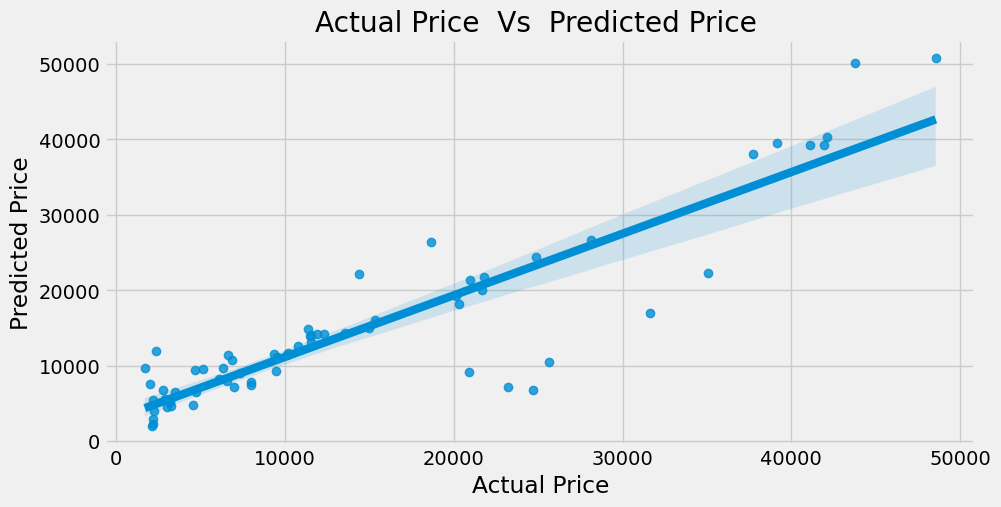

In [23]:
# plot the result with Gradient Boosting Regressor
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
out = pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
df2 = df.copy()
res = df2.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=res)
plt.title('Actual Price  Vs  Predicted Price ')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Conclusion

Gradient Boosting provides the best results in the Southwest, Southeast, and northest regions, and produces the lowest test error in the southeast region. 

We see that healthcare costs increase with age and are notably higher in smokers. Gender and number of children had the least amount of influence in the models overall.

The Gradient Boosting model in the northwest could potentially be improved with additional hyperparameter tuning or could implement a hybrid modeling approach that uses both boosted trees and Random Forest regression model to predict insurance claims by region.